In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
import pandas as pd
import json
import tiktoken

2024-05-05 22:30:37.117685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using this article: https://medium.com/@maxel333/creating-a-name-generator-with-lstm-9aaa600aeacf as inspiration

In [3]:
# Load and preprocess dataset
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    recipes = pd.DataFrame(data)
    # Tokenize titles
    embedded_titles = recipes['title']
    return embedded_titles

In [4]:
# Define the list of names
file_path = '/Users/carlymiles/Desktop/EECS/DIS-NN/rat-AI-touille/data/processing/stage_1.5/recipes_df.json'
names = load_data(file_path=file_path)

# Get encoding using tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base")

# Convert names to sequences of integers
sequences = tokenizer.encode_batch(names)
print(sequences)

[[37, 4588, 72584, 12831, 449, 54384], [2127, 331, 12831, 93379, 3213, 3161, 426, 25473, 612, 2522, 543, 919], [33, 888, 11, 31457, 1628, 72584, 12831], [37, 4588, 72584, 12831], [12331, 15846, 30260, 72584, 12831, 25, 64258, 72, 2947, 3357], [39972, 15386, 5250, 36623, 449, 2577, 16339, 3233], [50, 75730, 20287, 84, 6672, 3161, 21254, 21168, 1628, 72584, 62615, 31457], [50, 402, 683, 39247, 12093, 15386, 8529, 20798, 449, 2958, 83, 315, 72584, 62615], [2822, 12934, 818, 329, 435, 2734, 301, 612, 72584, 62615, 35918], [2127, 331, 62615, 435, 4108, 449, 4487, 11059, 32743, 41554, 57086, 14559], [50, 75730, 20287, 84, 6672, 3161, 21254, 21168, 1628, 72584, 62615, 31457], [59482, 279, 6017, 25, 26531, 4591, 64225, 449, 72584, 12831, 323, 12225, 1924], [19847, 349, 11, 71820, 683, 11, 323, 72584, 62615], [20613, 15832, 569, 42691, 64646, 3161, 480, 2739, 88, 12339, 1628, 72584, 62615, 4656, 412, 2439], [2127, 331, 62615, 323, 74956, 64477, 1037], [39972, 15386, 90538, 77873, 3161, 72584, 6

In [55]:
# Create input sequences and labels
X = []
y = []
for seq in sequences:
    for i in range(1, len(seq)):
        X.append(seq[:i])
        y.append(seq[i])

# Pad sequences for consistent input shape
max_seq_length = max([len(seq) for seq in X])
X = pad_sequences(X, maxlen=max_seq_length, padding='pre')

# One-hot encode labels
y = tf.keras.utils.to_categorical(y, num_classes=tokenizer.n_vocab)


In [59]:
len(y[0])

100277

In [61]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(tokenizer.n_vocab, 32, input_length=max_seq_length))
model.add(LSTM(64))
model.add(Dense(tokenizer.n_vocab, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 134, 32)           3208864   
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 100277)            6518005   
                                                                 
Total params: 9751701 (37.20 MB)
Trainable params: 9751701 (37.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define a custom callback to store training progress
class TrainingProgressCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.accuracies = []
        self.losses = []
        
    def on_epoch_end(self, epoch, logs=None):
        accuracy_percentage = logs.get('accuracy') * 100
        loss_percentage = logs.get('loss') * 100
        self.epochs.append(epoch + 1)
        self.accuracies.append(accuracy_percentage)
        self.losses.append(loss_percentage)

# Train the model with the progress callback
progress_callback = TrainingProgressCallback()
model.fit(X, y, epochs=100, verbose=1, callbacks=[progress_callback])

: 

In [8]:
# Display training progress in a table
df = pd.DataFrame({
    'Epoch': progress_callback.epochs,
    'Accuracy': progress_callback.accuracies,
    'Loss': progress_callback.losses
})
print(df)

    Epoch  Accuracy (%)    Loss (%)
0       1     31.704652  237.367415
1       2     44.108889  193.931079
2       3     50.572783  173.970222
3       4     54.801989  159.657371
4       5     57.641876  149.269271
..    ...           ...         ...
95     96     75.363243   82.826316
96     97     75.329620   82.706285
97     98     75.362039   82.640439
98     99     75.365645   82.612884
99    100     75.317609   82.549959

[100 rows x 3 columns]


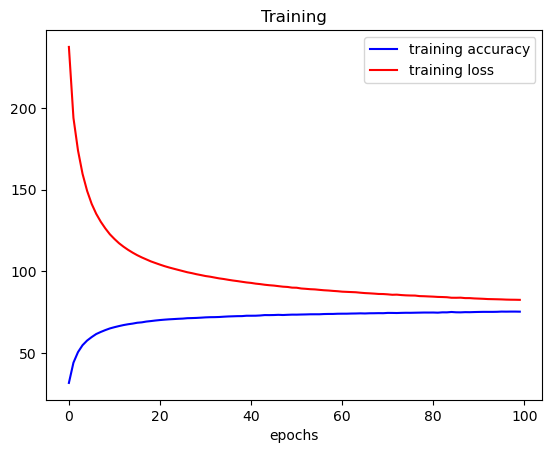

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(progress_callback.accuracies, c='blue', label='training accuracy')
plt.plot(progress_callback.losses, c='red', label='training loss')
plt.title('Training')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [10]:
model.save("model2.keras")

In [6]:
model = load_model('model1.keras')

In [31]:
print(tokenizer.word_index)
print(tokenizer.word_index['z'])

{' ': 1, 'a': 2, 'e': 3, 's': 4, 'i': 5, 't': 6, 'o': 7, 'r': 8, 'l': 9, 'n': 10, 'h': 11, 'd': 12, 'c': 13, 'm': 14, 'u': 15, 'p': 16, 'b': 17, 'w': 18, 'g': 19, 'f': 20, 'k': 21, '-': 22, 'y': 23, 'v': 24, ',': 25, 'z': 26, "'": 27, '(': 28, ')': 29, 'j': 30, '&': 31, ':': 32, 'q': 33, 'x': 34, 'é': 35, 'ç': 36, '’': 37, '"': 38, '/': 39, 'è': 40, 'ï': 41, 'ñ': 42, '2': 43, '1': 44, '–': 45, 'à': 46, 'â': 47, '5': 48, '.': 49, 'ù': 50, 'î': 51, '“': 52, '”': 53, '0': 54, '#': 55, '9': 56, '?': 57, '®': 58, '!': 59, '‘': 60, 'ã': 61, '§': 62, '3': 63, 'ó': 64, 'í': 65, '4': 66, '»': 67, '—': 68, 'ü': 69, '+': 70}
26


In [41]:
def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None

# Function to generate a new name
def generate_name_charLSTM(model, tokenizer, max_seq_length):
    seed_text = ""
    generated_text = ""
    predicted_id = -1
    
    while predicted_id != 1 and len(generated_text) <= 71:
        sequence = tokenizer.texts_to_sequences(texts=[seed_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_seq_length, padding='pre')
        
        predicted_probabilities = model.predict(sequence)[0]
        predicted_id = np.argmax(predicted_probabilities)
        generated_text += str(get_key_from_value(tokenizer.word_index, predicted_id))
        
    return generated_text

In [ ]:
def generate_name_tiktokenLSTM(model, tokenizer, max_seq_lenght):
    seed_text = ""
    generated_text = ""
    predicted_id = -1
    
    while predicted_id != 1 and len(generated_text) <= 71:
        sequence = tokenizer.decode(seed_text)
        sequence = pad_sequences([sequence], maxlen=max_seq_length, padding='pre')
        
        predicted_probabilities = model.predict(sequence)[0]
        predicted_id = np.argmax(predicted_probabilities)
        generated_text += str(get_key_from_value(tokenizer.word_index, predicted_id))
        
    return generated_text

In [48]:
print(generate_name(model, tokenizer=tokenizer, max_seq_length=134))


1/1 [==============================] - 0s 40ms/step
[[2.3537811e-10 7.6960772e-03 1.4079684e-01 1.3653008e-02 1.0784946e-01
  1.3893987e-02 3.6338374e-03 1.4318665e-02 6.5904041e-03 1.0783038e-03
  5.0211772e-03 5.5445667e-04 2.3632001e-03 1.6129740e-03 1.2717031e-01
  9.8076467e-05 1.6229852e-01 1.8854780e-02 9.9972691e-03 6.2997034e-03
  4.7926988e-02 3.9622858e-02 1.0678216e-03 1.8975603e-03 6.7256622e-02
  4.3825296e-04 1.7949925e-01 1.2585284e-04 8.4774401e-06 6.9346782e-03
  7.3760049e-03 2.5011037e-04 3.9590341e-07 2.7666655e-03 3.0357413e-08
  9.8915700e-07 2.2059119e-13 2.1414916e-04 6.5287299e-05 4.0619824e-07
  8.2516510e-07 2.5369409e-06 8.9071274e-19 2.1757534e-05 5.3287973e-04
  4.0647883e-05 1.6234734e-04 1.2746338e-15 5.5690439e-06 2.2432151e-36
  4.4552748e-09 4.0315096e-22 3.3756776e-13 8.8654412e-17 4.0230476e-13
  1.9501417e-12 8.8082691e-17 8.4204078e-25 6.4200994e-13 1.9114163e-08
  3.8894207e-10 3.6819365e-22 1.6102796e-16 7.7865026e-18 2.9396448e-20
  5.9473487e

''